In [1]:
import os
import sys
# sys.path.append('/Users/wangqiqian/Desktop/TrafficTDApython/')
sys.path.append('C:/Users/USER/Desktop/TrafficTDApython/')

current_dir_path = os.getcwd()
current_file_path = os.path.abspath(current_dir_path)
current_dir_path = os.path.dirname(current_file_path)
parent_dir_path = os.path.dirname(current_dir_path)

# os.chdir(current_dir_path + '\\ultils')
os.chdir(current_dir_path + '/ultils')
print(current_dir_path)

import time
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import prince
import matplotlib.cm as cm
from matplotlib.cm import get_cmap
from matplotlib.font_manager import FontProperties

from sklearn.cluster import AgglomerativeClustering

from functions import *
from chi import *
from regressionP import *
from models import *
from utils_v3 import *
from plots import *

# os.chdir('/Users/wangqiqian/Desktop/TrafficTDApython/')
os.chdir('C:/Users/USER/Desktop/TrafficTDApython/')

from Version3.tdamapper.core_old import MapperAlgorithm
from Version3.tdamapper.cover import CubicalCover
from Version3.tdamapper.clustering import FailSafeClustering
from Version3.tdamapper.plot import MapperLayoutInteractive
from tdamapper.plot import MapperPlot

# myfont = FontProperties(fname=r"/System/Library/Fonts/PingFang.ttc")
# sns.set(style="whitegrid", font=myfont.get_name())
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

c:\Users\USER\Desktop\TrafficTDApython


In [2]:
data1 = pd.read_csv("Data/NPA_TMA2_1.csv", low_memory=False)[:-2]
data2 = pd.read_csv("Data/NPA_TMA2_2.csv", low_memory=False)[:-2]
data3 = pd.read_csv("Data/NPA_TMA2_3.csv", low_memory=False)[:-2]
data4 = pd.read_csv("Data/NPA_TMA2_4_new.csv", low_memory=False)[:-2]
data5 = pd.read_csv("Data/NPA_TMA2_5.csv", low_memory=False)[:-2]
data6 = pd.read_csv("Data/NPA_TMA2_6_new.csv", low_memory=False)[:-2]
data7 = pd.read_csv("Data/NPA_TMA2_7.csv", low_memory=False)[:-2]
data8 = pd.read_csv("Data/NPA_TMA2_8.csv", low_memory=False)[:-2]
data9 = pd.read_csv("Data/NPA_TMA2_9.csv", low_memory=False)[:-2]
data10 = pd.read_csv("Data/NPA_TMA2_10.csv", low_memory=False)[:-2]

dataA2 = pd.concat([data1, data2, data3, data4, data5, data6, data7, data8, data9, data10], ignore_index=True)

dataA1 = pd.read_csv("Data/NPA_TMA1_V3.csv")[:-2]

In [49]:
select_lst = [
    # 月份是為了篩選每個月2萬筆
    '發生月份',

    '天候名稱', '光線名稱', 
    '道路類別-第1當事者-名稱', '速限-第1當事者', 
    '路面狀況-路面鋪裝名稱', '路面狀況-路面狀態名稱', '路面狀況-路面缺陷名稱',
    '道路障礙-障礙物名稱', '道路障礙-視距品質名稱', '道路障礙-視距名稱',
    '號誌-號誌種類名稱', '號誌-號誌動作名稱',
    '車道劃分設施-分道設施-快車道或一般車道間名稱', '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱',
    '當事者屬-性-別名稱', '當事者事故發生時年齡',
    '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱',
    '肇事逃逸類別名稱-是否肇逃',
    '死亡受傷人數',

    # 大類別
    '道路型態大類別名稱', '事故位置大類別名稱',
    '車道劃分設施-分向設施大類別名稱',
    '事故類型及型態大類別名稱', '當事者區分-類別-大類別名稱-車種', '當事者行動狀態大類別名稱',

    # 最初的值只有一種
    # '車輛撞擊部位大類別名稱-最初', 
    '車輛撞擊部位大類別名稱-其他',
    
    # 兩個相似且幾乎全部資料都一樣
    '肇因研判大類別名稱-主要',
    # '肇因研判大類別名稱-個別',
]
select_lst = dataA1.columns

def preprocess(input_data, select_lst):
    # 篩選到第一個順位，因為注重的是單次事故的情況
    sample_data = input_data[input_data['當事者順位'] == 1].reset_index(drop=True, inplace=False)
    sample_data = sample_data[sample_data['發生月份'] < 11]
    dataA = sample_data[select_lst]
    
    # 將資料分出死亡和受傷，合併到原本的資料後去除多餘的死亡受傷人數
    death_injury_data = split_death_injury(dataA['死亡受傷人數'])
    dist_df = pd.concat([dataA, death_injury_data], axis=1)

    # 補齊缺失值
    dist_df[select_lst] = dist_df[select_lst].fillna('未紀錄')

    # 速限範圍
    dist_df = dist_df[(dist_df['速限-第1當事者'] < 200) &
                      (dist_df['當事者事故發生時年齡'] < 100) &
                      (dist_df['當事者事故發生時年齡'] > 0)]

    dist_df.drop(columns=['死亡受傷人數'], inplace=True)
    
    return dist_df

dist_dfA1 = preprocess(dataA1, select_lst)
dist_dfA2 = preprocess(dataA2, select_lst)

pass_A2 = dist_dfA2[dist_dfA2['當事者行動狀態大類別名稱'] == '人的狀態']
pass_A1 = dist_dfA1[dist_dfA1['當事者行動狀態大類別名稱'] == '人的狀態']

# drop
pass_A1.drop(columns=['當事者行動狀態大類別名稱'], inplace=True)
pass_A2.drop(columns=['當事者行動狀態大類別名稱'], inplace=True)

pass_A2 = pass_A2[(pass_A2['行動電話或電腦或其他相類功能裝置名稱'] != '未紀錄') &
                   (pass_A2['行動電話或電腦或其他相類功能裝置名稱'] != '不明')]
pass_A1 = pass_A1[(pass_A1['行動電話或電腦或其他相類功能裝置名稱'] != '未紀錄') &
                   (pass_A1['行動電話或電腦或其他相類功能裝置名稱'] != '不明')]

C:\Users\USER\AppData\Local\Temp\ipykernel_9836\3538903121.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\USER\AppData\Local\Temp\ipykernel_9836\3538903121.py:61: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [90]:
print(pass_A1.shape)
print(pass_A2.shape)


(58, 51)
(3038, 51)


In [50]:
# Concat
rbind_data = pd.concat([pass_A1, pass_A2], axis=0, ignore_index=True)
rbind_data.drop(columns=['發生月份'], inplace=True)

bins_age = [0, 14, 24, 34, 44, 54, 64, 74, float('inf')]
labels_age = ['未滿15歲', '15~24', '25~34', '35~44', '45~54', '55~64', '65~74', '75+']

rbind_data['當事者事故發生時年齡'] = pd.cut(rbind_data['當事者事故發生時年齡'], bins=bins_age, labels=labels_age, right=False)

bins_speed = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, float('inf')]
labels_speed = ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100', '101-110', '110+']

rbind_data['速限-第1當事者'] = pd.cut(rbind_data['速限-第1當事者'], bins=bins_speed, labels=labels_speed, right=False).astype(str)

# Dummy
# rbind_data["速限-第1當事者"] = rbind_data["速限-第1當事者"].astype(str)
dummy_data = pd.get_dummies(rbind_data)

print('dummy_data:', dummy_data.shape)

data_to_map = dummy_data.drop(['死亡', '受傷'], axis=1)
mapper_numpy = data_to_map.to_numpy()
# rbind_data['顯著特徵'] = rbind_data['道路型態子類別名稱'] + ',' + rbind_data['號誌-號誌動作名稱'] + ',' + rbind_data['天候名稱']

dummy_data: (3096, 3327)


篩選掉未紀錄資料以及分類人的狀態以及車的狀態

由於人的狀態資料量已經很少，所以不進行下採樣

# Kmode

In [ ]:
from kmodes.kmodes import KModes

data_for_kmode = rbind_data.drop(['死亡', '受傷', 'color_for_plot'], axis=1)

print(data_for_kmode.columns)

cost = []
all_results = {}
K = range(1, 10)

for k in K:
    
    km = KModes(
    n_clusters=k,
    init='Huang',
    verbose=1,
    random_state=42,
    n_jobs=5
    )

    labels = km.fit_predict(data_for_kmode)
    cost.append(km.cost_)
    all_results[k] = {
        'cost': km.cost_,
        'labels': labels,
        'centroids': km.cluster_centroids_
    }

optimal_k = K[cost.index(min(cost))]
optimal_result = all_results[optimal_k]

plt.figure(figsize=(8, 5))
plt.plot(K, cost, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Cost')
plt.title('Elbow Method for Optimal k')
plt.show()


# pd.Series(all_results[4]['labels']).value_counts()
# rbind_data['Cluster'] = all_results[4]['labels']

In [54]:
rbind_data['Cluster'] = all_results[2]['labels']

# MCA

In [ ]:
mca = prince.MCA(
    one_hot=False,
    n_components=12,
    n_iter=30,
    copy=True,
    check_input=True,
    random_state=42
)

mca.fit(data_to_map)
lens = mca.transform(data_to_map)

print(mca.eigenvalues_summary)

eigenvalues = mca.eigenvalues_

components = range(0, len(eigenvalues))

variance = mca.eigenvalues_summary['% of variance']

plt.figure(figsize=(10, 6))
plt.plot(components, eigenvalues, marker='o', linestyle='--')
plt.title("Scree Plot")
plt.xlabel("Component")
plt.ylabel("Eigenvalue")
plt.xticks(components)
plt.grid(True)
plt.show()

In [ ]:
col_coordinate = mca.column_coordinates(data_to_map)

col_coordinate['dummy_index'] = range(len(col_coordinate))  # 為每個欄位分配索引

# Normalize the 'dummy_index' for mapping to colormap
norm = plt.Normalize(vmin=col_coordinate['dummy_index'].min(), vmax=col_coordinate['dummy_index'].max())
cmap = cm.viridis  # 選擇漸層色盤，例如 viridis, plasma, inferno 等

plt.figure(figsize=(20, 12))

plt.gca().set_facecolor('white')

# 繪製散點圖，顏色根據 dummy_index 映射
scatter = plt.scatter(
    col_coordinate[0],  # X coordinate
    col_coordinate[1],  # Y coordinate
    c=col_coordinate['dummy_index'],  # 使用索引作為顏色映射
    cmap=cmap,
    alpha=0.7
)

# Adding labels with colors matching the scatter plot
offset = 0.15
for i, label in enumerate(col_coordinate.index):
    plt.text(
        col_coordinate.iloc[i, 0],  # X coordinate
        col_coordinate.iloc[i, 1] + offset,  # Y coordinate
        str(label),  # 假設 label 包含中文
        fontsize=10,
        ha='center', 
        va='center',
        color=cmap(norm(col_coordinate.iloc[i]['dummy_index'])),  # 文字顏色與點顏色一致
        # rotation=30
    )

# Add colorbar
# cbar = plt.colorbar(scatter)
# cbar.set_label("Field Index (Gradient)", fontsize=12)

# Axes lines and grid
plt.axhline(0, color='grey', linestyle='--', linewidth=0.5)
plt.axvline(0, color='grey', linestyle='--', linewidth=0.5)
# plt.title("MCA", fontsize=16)
plt.xlabel("Dimension 1", fontsize=12)
plt.ylabel("Dimension 2", fontsize=12)
plt.grid(True)

plt.show()

# Gridsearch

In [6]:
Overlap = [4]
Interval = [7]
detailed_results = []

for overlap in Overlap:
    silhouette_for_intervals = []

    for interval in Interval:
        try:
            print(f'overlap: {overlap}, interval: {interval}')

            mapper_algo = MapperAlgorithm(
                cover=CubicalCover(
                    n_intervals=interval,
                    overlap_frac=overlap / 10
                ),
                clustering=FailSafeClustering(
                    AgglomerativeClustering(
                        n_clusters=2,
                        linkage='ward'
                    )
                ),
                n_jobs=1
            )

            mapper_info = mapper_algo.fit_transform(mapper_numpy, lens)
            silhouette_for_intervals.append(mapper_info[1])

            result = {
                "overlap": overlap,
                "interval": interval,
                "silhouette": mapper_info[1],
                "mapper_info": mapper_info
            }

            detailed_results.append(result)

            filename = f"C:/Users/USER/Desktop/TrafficTDApython/Version3/Gridsearch/Component12Pass/results_o{overlap}i{interval}.pkl"
            # filename = f"/Users/wangqiqian/Desktop/TrafficTDApython/Version3/Gridsearch/Component12Pass/results_o{overlap}i{interval}.pkl"

            with open(filename, 'wb') as file:
                pickle.dump(result, file)

            print(f"Results saved to {filename}")

        except Exception as e:
            print(f"Error for overlap={overlap}, interval={interval}: {e}")

            continue

overlap: 4, interval: 7


12/28/2024 08:38:19 PM core WARNING: Unable to perform clustering on local chart: Found array with 1 sample(s) (shape=(1, 115)) while a minimum of 2 is required by AgglomerativeClustering.
12/28/2024 08:38:19 PM core WARNING: Unable to perform clustering on local chart: Found array with 1 sample(s) (shape=(1, 115)) while a minimum of 2 is required by AgglomerativeClustering.
12/28/2024 08:38:19 PM core WARNING: Unable to perform clustering on local chart: Found array with 1 sample(s) (shape=(1, 115)) while a minimum of 2 is required by AgglomerativeClustering.
12/28/2024 08:38:19 PM core WARNING: Unable to perform clustering on local chart: Found array with 1 sample(s) (shape=(1, 115)) while a minimum of 2 is required by AgglomerativeClustering.
12/28/2024 08:38:19 PM core WARNING: Unable to perform clustering on local chart: Found array with 1 sample(s) (shape=(1, 115)) while a minimum of 2 is required by AgglomerativeClustering.
12/28/2024 08:38:19 PM core WARNING: Unable to perform 

Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Gridsearch/Component12Pass/results_o4i7.pkl


In [7]:
detailed_results_df = pd.DataFrame(detailed_results)

# output_file = 'C:/Users/USER/Desktop/TrafficTDApython/Version3/Gridsearch/Component12Pass/results_o4i8.pkl'

# with open(output_file, 'rb') as f:
#     detailed_results_df = pickle.load(f)

# 正確分佈的seed = 87

In [ ]:
choose = '道路型態大類別名稱'

for i in [87]:
    mapper_plotter = MapperPlotter(detailed_results_df['mapper_info'][0], rbind_data, seed=i, iterations=100)
    mapper_plot = mapper_plotter.create_mapper_plot(choose, most_common_encoded_label, avg=False)
    full_info = mapper_plotter.extract_data()
    mapper_plotter.map_colors(choose, size=0, threshold=0, range_lst=[-0.2, 0.1, 0.15, -0.18])
    mapper_plotter.plot(choose, avg=False, set_label=True, size=100000)
    # mapper_plotter.plot_3d_interactive(choose, avg=False, set_label=True, size=100000,
    #                                    save_path=f"/Users/wangqiqian/Desktop/TrafficTDApython/Version3/GridSearch/Mapper/Pass/o4i8_{choose}.html")

In [ ]:
lst = ['天候名稱', '光線名稱',
       '道路類別-第1當事者-名稱', '速限-第1當事者', '道路型態大類別名稱', '道路型態子類別名稱', '事故位置大類別名稱',
       '事故位置子類別名稱', '路面狀況-路面鋪裝名稱', '路面狀況-路面狀態名稱', '路面狀況-路面缺陷名稱', '道路障礙-障礙物名稱',
       '道路障礙-視距品質名稱', '道路障礙-視距名稱', '號誌-號誌種類名稱', '號誌-號誌動作名稱',
       '車道劃分設施-分向設施大類別名稱', '車道劃分設施-分向設施子類別名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
       '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱', '事故類型及型態大類別名稱',
       '事故類型及型態子類別名稱', '肇因研判大類別名稱-主要', '肇因研判子類別名稱-主要',
       '當事者區分-類別-大類別名稱-車種', '當事者區分-類別-子類別名稱-車種', '當事者屬-性-別名稱', '當事者事故發生時年齡',
       '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱', '當事者行動狀態子類別名稱', '車輛撞擊部位大類別名稱-最初',
       '車輛撞擊部位子類別名稱-最初', '車輛撞擊部位大類別名稱-其他', '車輛撞擊部位子類別名稱-其他', '肇因研判大類別名稱-個別',
       '肇因研判子類別名稱-個別', '肇事逃逸類別名稱-是否肇逃''死亡', '受傷', 'Cluster', '顯著特徵']
lst = ['Cluster']

for choose in lst:
       try:   
              mapper_plotter = MapperPlotter(detailed_results_df['mapper_info'][0], rbind_data, seed=44, iterations=100)
              mapper_plotter.create_mapper_plot(choose, most_common_encoded_label, avg=False)
              full_info = mapper_plotter.extract_data()
              mapper_plotter.map_colors(choose, size=0, threshold=30, range_lst=[-0.2, 0.1, 0.15, -0.18])
              mapper_plotter.plot(choose, avg=False, set_label=True, size=100000,
                     # save_path=f"/Users/wangqiqian/Desktop/TrafficTDApython/Version3/GridSearch/MapperColor/Pass/o4_i8_{choose}.png"
                     save_path=f"C:/Users/USER/Desktop/TrafficTDApython/Version3/GridSearch/MapperColor/Pass/o4_i7_{choose}.png"
                     )
       except Exception as e:
              print(e)
              continue

In [ ]:
choose = 'Cluster'
# choose = '死亡'

unique_categories = rbind_data[choose].unique()
# unique_categories.sort()

for index in range(detailed_results_df.shape[0]):
    # 統一顏色
    color_palette = get_cmap("tab20", len(unique_categories))
    color_mapping_fixed = {category: color_palette(i) for i, category in enumerate(unique_categories)}

    mapper_plotter = MapperPlotter(detailed_results_df['mapper_info'].iloc[index][0], 
                                rbind_data, detailed_results_df)
    mapper_plotter.create_mapper_plot(choose, most_common_encoded_label, avg=False)
    mapper_plotter.extract_data()
    mapper_plotter.map_colors(choose, color_mapping_fixed, size=0)
    mapper_plotter.plot(choose, avg=False, set_label=True, size=100000,
                        save_path=f"C:/Users/USER/Desktop/TrafficTDApython/Version3/GridSearch/Mapper/Pass/o{detailed_results_df['overlap'].iloc[index]}_i{detailed_results_df['interval'].iloc[index]}.png")

In [ ]:
for choose in lst:
    unique_categories = rbind_data[choose].dropna().unique()
    # 統一顏色
    color_palette = get_cmap("tab20", len(unique_categories))
    color_mapping_fixed = {category: color_palette(i) for i, category in enumerate(unique_categories)}

    # mapper_plotter = MapperPlotter(detailed_results_df['mapper_info'].iloc[33][0],
    mapper_plotter = MapperPlotter(detailed_results_df['mapper_info'].iloc[0], rbind_data, seed=10)
    mapper_plotter.create_mapper_plot(choose, most_common_encoded_label, avg=False)
    full_info = mapper_plotter.extract_data()
    mapper_plotter.map_colors(choose, size=0, threshold=8 , range_lst=[-0.3, 0.3, 0.4, -0.2]) # 篩選資料
    mapper_plotter.plot(choose, avg=False, set_label=True, size=100000, # 限制點的大小
                        save_path=f"C:/Users/USER/Desktop/TrafficTDApython/Version3/GridSearch/MapperColor/Pass/o4_i8_{choose}.png")

# Polygon

In [9]:
print(len(get_unique_ids(full_info)))

3096


In [ ]:
from shapely.geometry import Point, Polygon

rectangle1 = Polygon([(-0.16, -0.05), (-0.16, 0.1), (-0.05, 0.1), (-0.05, 0.03)])
rectangle2 = Polygon([(-0.16, -0.05), (-0.05, 0.03), (0, -0.05)])
rectangle3 = Polygon([(-0.05, 0.03), (-0.05, 0.1), (0.1, 0.1), (-0.015, -0.03)]) 
rectangle4 = Polygon([(0.06, -0.2), (-0.015, -0.03), (0.1, 0.1), (0.15, 0)]) 

# 限制會導致full_info的資料量減少
range_lst=[-0.5, 0.2, 0.2, -0.25]
filtered_full_info = full_info[(full_info['x'] > range_lst[0]) & 
          (full_info['y'] < range_lst[2]) & 
          (full_info['x'] < range_lst[1]) & 
          (full_info['y'] > range_lst[3])]
filtered_full_info = full_info

# 檢查每個點是否在任意一個區塊內
inside_indices_1 = filtered_full_info.apply(lambda row: Point(row['x'], row['y']).within(rectangle1), axis=1)
inside_indices_2 = filtered_full_info.apply(lambda row: Point(row['x'], row['y']).within(rectangle2), axis=1)
inside_indices_3 = filtered_full_info.apply(lambda row: Point(row['x'], row['y']).within(rectangle3), axis=1)
inside_indices_4 = filtered_full_info.apply(lambda row: Point(row['x'], row['y']).within(rectangle4), axis=1)

label_0 = filtered_full_info[inside_indices_1]
label_1 = filtered_full_info[inside_indices_2]
label_2 = filtered_full_info[inside_indices_3]
label_3 = filtered_full_info[inside_indices_4]

# 提取區域內和區域外的數據
all_inside_indices = inside_indices_1 | inside_indices_2 | inside_indices_3 | inside_indices_4
outside_indices = ~all_inside_indices

label_out = filtered_full_info[outside_indices]

# assert label_0.shape[0] + label_1.shape[0] + label_2.shape[0] + label_3.shape[0] + label_out.shape[0] == filtered_full_info.shape[0]

plt.figure(figsize=(10, 8))

# Plot points inside each polygon
plt.scatter(label_0['x'], label_0['y'], color='green', s=10)
plt.scatter(label_1['x'], label_1['y'], color='blue', s=10)
plt.scatter(label_2['x'], label_2['y'], color='purple', s=10)
plt.scatter(label_3['x'], label_3['y'], color='orange', s=10)
plt.scatter(label_out['x'], label_out['y'], color='red', s=10)

# Fill polygons with semi-transparent colors
for rect, color, alpha in zip([rectangle1, rectangle2, rectangle3, rectangle4], 
                              ['green', 'blue', 'purple', 'orange'], 
                              [0.2, 0.2, 0.2, 0.2]):
    x, y = rect.exterior.xy
    plt.fill(x, y, color=color, alpha=alpha)

# Formatting
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid(True)
plt.axis("equal")
# plt.title("Passanger Topology")
plt.show()

In [325]:
# 獲取每個label的index
count_0 = get_unique_ids(label_0)
count_1 = get_unique_ids(label_1)
count_2 = get_unique_ids(label_2)
count_3 = get_unique_ids(label_3)
count_out = get_unique_ids(label_out)

index_to_groups = {}

# 將索引與群體的關係記錄下來
for group_name, group_indexes in zip(
    ["full_0", "full_1", "full_2", "full_3", "full_out"],
    [count_0, count_1, count_2, count_3, count_out],
):
    for idx in group_indexes:
        if idx not in index_to_groups:
            index_to_groups[idx] = set()
        index_to_groups[idx].add(group_name)

# 找交集索引
intersection_indexes = {idx for idx, groups in index_to_groups.items() if len(groups) > 1}

# 移除交集的index
count_0 = [i for i in count_0 if i not in intersection_indexes]
count_1 = [i for i in count_1 if i not in intersection_indexes]
count_2 = [i for i in count_2 if i not in intersection_indexes]
count_3 = [i for i in count_3 if i not in intersection_indexes]
count_out = [i for i in count_out if i not in intersection_indexes]


full_0 = rbind_data.loc[count_0]
full_1 = rbind_data.loc[count_1]
full_2 = rbind_data.loc[count_2]
full_3 = rbind_data.loc[count_3]
full_out = rbind_data.loc[count_out]
overlap_data = rbind_data.loc[intersection_indexes]

# 確認所有資料都被獲取
assert len(count_0) == full_0.shape[0]
assert len(count_1) == full_1.shape[0]
assert len(count_2) == full_2.shape[0]
assert len(count_3) == full_3.shape[0]
assert len(count_out) == full_out.shape[0]

print(full_0.shape[0] + full_1.shape[0] + full_2.shape[0] + full_3.shape[0] + full_out.shape[0] + overlap_data.shape[0])
print(rbind_data.shape[0])

3096
3096


C:\Users\USER\AppData\Local\Temp\ipykernel_9836\269421182.py:36: FutureWarning:

Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.



In [112]:
print(full_0['死亡'].value_counts())
print(full_1['死亡'].value_counts())
print(full_2['死亡'].value_counts())
print(full_3['死亡'].value_counts())
print(full_out['死亡'].value_counts())
print(overlap_data['死亡'].value_counts())

0    511
1     12
Name: 死亡, dtype: int64
0    96
1     1
Name: 死亡, dtype: int64
0    385
1      2
Name: 死亡, dtype: int64
0    1790
1      32
2       1
Name: 死亡, dtype: int64
0    151
1      9
Name: 死亡, dtype: int64
0    105
1      1
Name: 死亡, dtype: int64


# 統計分析

In [108]:
chi_lst = [
    '天候名稱', '光線名稱', '道路類別-第1當事者-名稱', '速限-第1當事者', '路面狀況-路面鋪裝名稱',
    '路面狀況-路面狀態名稱', '路面狀況-路面缺陷名稱', '道路障礙-障礙物名稱', '道路障礙-視距品質名稱', '道路障礙-視距名稱',
    '號誌-號誌種類名稱', '號誌-號誌動作名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
    '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱', '當事者屬-性-別名稱', '當事者事故發生時年齡',
    '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱', '肇事逃逸類別名稱-是否肇逃', '道路型態大類別名稱',
    '事故位置大類別名稱', '車道劃分設施-分向設施大類別名稱', '事故類型及型態大類別名稱', '當事者區分-類別-大類別名稱-車種',
    '車輛撞擊部位大類別名稱-其他']


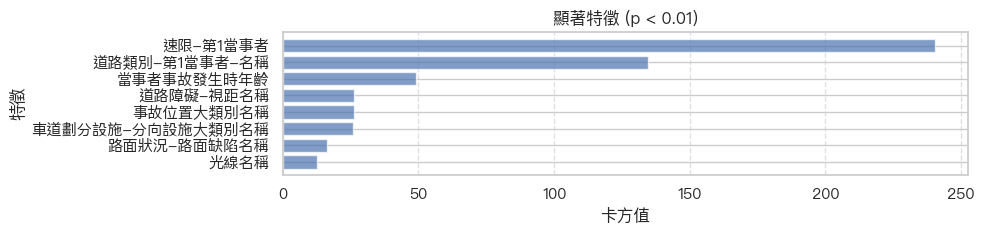

In [32]:
from scipy.stats import chi2_contingency

chi_lst = [
    '天候名稱', '光線名稱', '道路類別-第1當事者-名稱', '速限-第1當事者', '路面狀況-路面鋪裝名稱',
    '路面狀況-路面狀態名稱', '路面狀況-路面缺陷名稱', '道路障礙-障礙物名稱', '道路障礙-視距品質名稱', '道路障礙-視距名稱',
    '號誌-號誌種類名稱', '號誌-號誌動作名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
    '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱', '當事者屬-性-別名稱', '當事者事故發生時年齡',
    '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱', '肇事逃逸類別名稱-是否肇逃', '道路型態大類別名稱',
    '事故位置大類別名稱', '車道劃分設施-分向設施大類別名稱', '事故類型及型態大類別名稱', '當事者區分-類別-大類別名稱-車種',
    '車輛撞擊部位大類別名稱-其他']

results = []
rbind_data['death'] = rbind_data['死亡'].apply(lambda x: 1 if x >= 1 else 0)

for chi_value in chi_lst:
    contingency_table = pd.crosstab(rbind_data[chi_value], rbind_data['death'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    if p < 0.01:  # 只篩選顯著結果
        results.append({'變數': chi_value, '卡方值': chi2, '自由度': dof, 'p值': p})

# 將結果轉為資料框
df_results = pd.DataFrame(results).sort_values(by='卡方值', ascending=True)

# 視覺化：條形圖
plt.figure(figsize=(10, 2.5))
plt.barh(df_results['變數'], df_results['卡方值'], alpha=0.7)
plt.xlabel('卡方值')
plt.ylabel('特徵')
plt.title('顯著特徵 (p < 0.01)')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [219]:
plot_column = '死亡'

data_dict = {
    "正常號誌、四岔路": full_0[plot_column].value_counts(),
    "正常號誌、直路": full_1[plot_column].value_counts(),
    "無號誌、三岔路": full_2[plot_column].value_counts(),
    "無號誌、直路": full_3[plot_column].value_counts(),
    "離群值": full_out[plot_column].value_counts(),
    "覆蓋值": overlap_data[plot_column].value_counts(),
}

# 將資料轉為 DataFrame，便於比較
comparison_df = pd.DataFrame(data_dict).fillna(0)
comparison_df = comparison_df.sort_values(by='正常號誌、四岔路', ascending=False)
comparison_df

,正常號誌、四岔路,正常號誌、直路,無號誌、三岔路,無號誌、直路,離群值,覆蓋值
0,511.0,96.0,385.0,1790,151.0,105.0
1,12.0,1.0,2.0,32,9.0,1.0
2,0.0,0.0,0.0,1,0.0,0.0


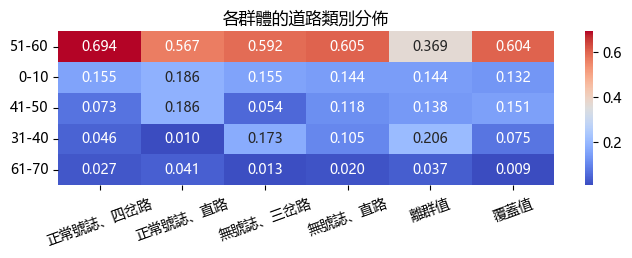

In [213]:
plot_column = '速限-第1當事者'

data_dict = {
    "正常號誌、四岔路": full_0[plot_column].value_counts(normalize=True),
    "正常號誌、直路": full_1[plot_column].value_counts(normalize=True),
    "無號誌、三岔路": full_2[plot_column].value_counts(normalize=True),
    "無號誌、直路": full_3[plot_column].value_counts(normalize=True),
    "離群值": full_out[plot_column].value_counts(normalize=True),
    "覆蓋值": overlap_data[plot_column].value_counts(normalize=True),
}

# 將資料轉為 DataFrame，便於比較
comparison_df = pd.DataFrame(data_dict).fillna(0)
comparison_df = comparison_df.sort_values(by='正常號誌、四岔路', ascending=False)
comparison_df

# heatmap
plt.figure(figsize=(8, 2))
sns.heatmap(comparison_df.head(5), annot=True, cmap='coolwarm', fmt=".3f")
plt.title(f"各群體的道路類別分佈")
plt.xticks(rotation=20)
plt.show()

In [120]:
full_0.columns

Index(['發生年度', '發生日期', '發生時間', '事故類別名稱', '處理單位名稱警局層', '發生地點', '天候名稱', '光線名稱',
       '道路類別-第1當事者-名稱', '速限-第1當事者', '道路型態大類別名稱', '道路型態子類別名稱', '事故位置大類別名稱',
       '事故位置子類別名稱', '路面狀況-路面鋪裝名稱', '路面狀況-路面狀態名稱', '路面狀況-路面缺陷名稱', '道路障礙-障礙物名稱',
       '道路障礙-視距品質名稱', '道路障礙-視距名稱', '號誌-號誌種類名稱', '號誌-號誌動作名稱',
       '車道劃分設施-分向設施大類別名稱', '車道劃分設施-分向設施子類別名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
       '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱', '事故類型及型態大類別名稱',
       '事故類型及型態子類別名稱', '肇因研判大類別名稱-主要', '肇因研判子類別名稱-主要', '當事者順位',
       '當事者區分-類別-大類別名稱-車種', '當事者區分-類別-子類別名稱-車種', '當事者屬-性-別名稱', '當事者事故發生時年齡',
       '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱', '當事者行動狀態子類別名稱', '車輛撞擊部位大類別名稱-最初',
       '車輛撞擊部位子類別名稱-最初', '車輛撞擊部位大類別名稱-其他', '車輛撞擊部位子類別名稱-其他', '肇因研判大類別名稱-個別',
       '肇因研判子類別名稱-個別', '肇事逃逸類別名稱-是否肇逃', '經度', '緯度', '死亡', '受傷', '顯著特徵',
       'Cluster', 'color_for_plot'],
      dtype='object')

# 道路類別-第1當事者-名稱

In [216]:
plot_column = '道路類別-第1當事者-名稱'

data_dict = {
    "正常號誌、四岔路": full_0[plot_column].value_counts(),
    "正常號誌、直路": full_1[plot_column].value_counts(),
    "無號誌、三岔路": full_2[plot_column].value_counts(),
    "無號誌、直路": full_3[plot_column].value_counts(),
    "覆蓋值": overlap_data[plot_column].value_counts(),
    "離群值": full_out[plot_column].value_counts(),
    
}

# 將資料轉為 DataFrame，便於比較
comparison_df = pd.DataFrame(data_dict).fillna(0)
comparison_df = comparison_df.sort_values(by='正常號誌、四岔路', axis=0, ascending=False)
comparison_df

,正常號誌、四岔路,正常號誌、直路,無號誌、三岔路,無號誌、直路,覆蓋值,離群值
市區道路,442.0,81.0,318.0,1473.0,77.0,85.0
村里道路,41.0,4.0,36.0,203.0,19.0,29.0
其他,17.0,6.0,16.0,50.0,1.0,17.0
縣道,10.0,3.0,11.0,34.0,4.0,5.0
省道,8.0,2.0,4.0,28.0,1.0,11.0
鄉道,5.0,1.0,2.0,27.0,4.0,1.0
國道,0.0,0.0,0.0,0.0,0.0,11.0
專用道路,0.0,0.0,0.0,8.0,0.0,0.0
快速(公)道,0.0,0.0,0.0,0.0,0.0,1.0


In [217]:
data_dict = {
    "正常號誌、四岔路": full_0[plot_column].value_counts(normalize=True),
    "正常號誌、直路": full_1[plot_column].value_counts(normalize=True),
    "無號誌、三岔路": full_2[plot_column].value_counts(normalize=True),
    "無號誌、直路": full_3[plot_column].value_counts(normalize=True),
    "覆蓋值": overlap_data[plot_column].value_counts(normalize=True),
    "離群值": full_out[plot_column].value_counts(normalize=True),
    
}

# 將資料轉為 DataFrame，便於比較
comparison_df = pd.DataFrame(data_dict).fillna(0)
comparison_df = comparison_df.sort_values(by='正常號誌、四岔路', axis=0, ascending=False)

categories_to_merge = ["縣道", "省道", "鄉道", "國道", "專用道路", "快速(公)道"]
comparison_df.loc["其他"] += comparison_df.loc[categories_to_merge].sum()
comparison_df = comparison_df.drop(index=categories_to_merge)
comparison_df

,正常號誌、四岔路,正常號誌、直路,無號誌、三岔路,無號誌、直路,覆蓋值,離群值
市區道路,0.845124,0.835052,0.821705,0.808009,0.726415,0.53125
村里道路,0.078394,0.041237,0.093023,0.111355,0.179245,0.18125
其他,0.076482,0.123711,0.085271,0.080636,0.094340,0.28750


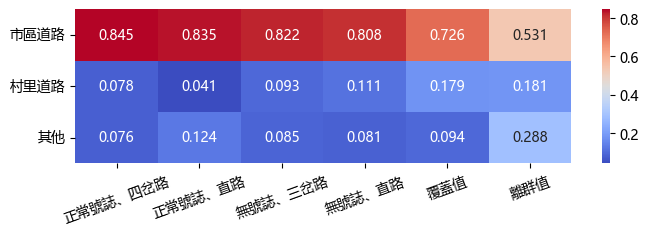

In [218]:
# heatmap
plt.figure(figsize=(8, 2))
sns.heatmap(comparison_df.head(3), annot=True, cmap='coolwarm', fmt=".3f")
# plt.title(f"各群體的道路類別分佈")
plt.xticks(rotation=20)
plt.show()

# 嚴重程度

In [338]:
def get_severity(input_data):
    """
    更新嚴重程度欄位邏輯：
    - 死亡 > 0 時，設定為 2
    - 死亡 = 0 且受傷 = 1 時，設定為 0
    - 死亡 = 0 且受傷 > 1 時，設定為 1
    """
    def severity_logic(row):
        if row['死亡'] > 0:
            return '死亡'
        elif row['死亡'] == 0 and row['受傷'] == 1:
            return '受傷1'
        elif row['死亡'] == 0 and row['受傷'] > 1:
            return '受傷1+'
        else:
            return 0

    input_data['嚴重程度'] = input_data.apply(severity_logic, axis=1)
    return input_data

full_0_s = get_severity(full_0)
full_1_s = get_severity(full_1)
full_2_s = get_severity(full_2)
full_3_s = get_severity(full_3)
full_out_s = get_severity(full_out)
overlap_data_s = get_severity(overlap_data)

In [339]:
plot_column = '嚴重程度'

data_dict = {
    "正常號誌、四岔路": full_0[plot_column].value_counts(),
    "正常號誌、直路": full_1[plot_column].value_counts(),
    "無號誌、三岔路": full_2[plot_column].value_counts(),
    "無號誌、直路": full_3[plot_column].value_counts(),
    "覆蓋值": overlap_data[plot_column].value_counts(),
    "離群值": full_out[plot_column].value_counts(),
    
}

# 將資料轉為 DataFrame，便於比較
comparison_df = pd.DataFrame(data_dict).fillna(0)
total_row = comparison_df.sum(axis=0)
comparison_df.loc["Total"] = total_row
# comparison_df.loc["Total"] = comparison_df.loc["Total"].astype(int)
comparison_df = comparison_df.sort_values(by='正常號誌、四岔路', axis=0, ascending=False)
comparison_df

,正常號誌、四岔路,正常號誌、直路,無號誌、三岔路,無號誌、直路,覆蓋值,離群值
Total,523,97,387,1823,106,160
受傷1,300,58,192,826,51,88
受傷1+,211,38,193,964,54,63
死亡,12,1,2,33,1,9


In [340]:
data_dict = {
    "正常號誌、四岔路": full_0[plot_column].value_counts(normalize=True),
    "正常號誌、直路": full_1[plot_column].value_counts(normalize=True),
    "無號誌、三岔路": full_2[plot_column].value_counts(normalize=True),
    "無號誌、直路": full_3[plot_column].value_counts(normalize=True),
    "覆蓋值": overlap_data[plot_column].value_counts(normalize=True),
    "離群值": full_out[plot_column].value_counts(normalize=True),
    
}

# 將資料轉為 DataFrame，便於比較
comparison_df = pd.DataFrame(data_dict).fillna(0)
comparison_df.loc["Total"] = total_row
comparison_df = comparison_df.sort_values(by='正常號誌、四岔路', axis=0, ascending=False)
comparison_df

,正常號誌、四岔路,正常號誌、直路,無號誌、三岔路,無號誌、直路,覆蓋值,離群值
Total,523.000000,97.000000,387.000000,1823.000000,106.000000,160.00000
受傷1,0.573614,0.597938,0.496124,0.453099,0.481132,0.55000
受傷1+,0.403442,0.391753,0.498708,0.528799,0.509434,0.39375
死亡,0.022945,0.010309,0.005168,0.018102,0.009434,0.05625


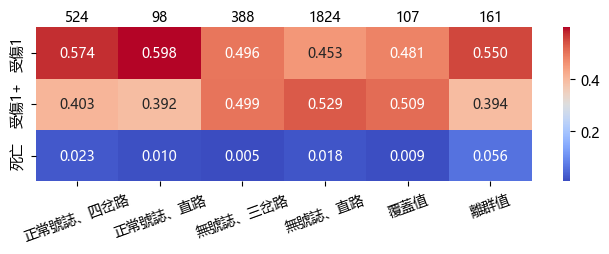

In [341]:
# 重新計算 Total 行，並添加到 DataFrame
comparison_df.loc["Total"] = comparison_df.sum(axis=0)

# 獲取 Total 行數據
total_row = comparison_df.loc["Total"]

# 提取僅包含數值的列，並移除 Total 行
numeric_df = comparison_df.select_dtypes(include=[float, int]).drop("Total")

# 繪製 heatmap
plt.figure(figsize=(8, 2))
sns.heatmap(numeric_df.tail(3), annot=True, cmap='coolwarm', fmt=".3f")

# 添加總數標註在每個欄位的頂部
for i, total in enumerate(total_row):
    plt.text(i + 0.5, -0.2, f"{int(total)}", ha='center', va='center', fontsize=10, color='black')

# 調整外觀
plt.xticks(rotation=20)
plt.show()


# 分類模型

In [ ]:
def get_train_test_data(input_data):
    input_data['y'] = input_data['死亡'].apply(lambda x: 1 if x >= 1 else 0)
    
    new_input_data = input_data.drop(columns=['受傷', '死亡'], inplace=False)
    
    X = new_input_data.drop(columns=['y'])
    y = new_input_data['y']

    return X, y

X0, y0 = get_train_test_data(full_0)
X1, y1 = get_train_test_data(full_1)
X2, y2 = get_train_test_data(full_2)
X3, y3 = get_train_test_data(full_3)
Xout, yout = get_train_test_data(full_out)
Xfull, yfull = get_train_test_data(dummy_data)

In [ ]:
full_svc_matrix, full_svc_score, full_svc_cm, full_svc_y_resampled_test, full_svc_decision_scores = linear_svc_cm_gridsearch(Xfull, yfull, threshold=-1.2)
full_logit_matrix, full_logit_score, full_logit_cm, full_logit_y_resampled_test, full_logit_decision_scores = logistic_cm_gridsearch(Xfull, yfull, threshold=0.013)

print(full_svc_cm, full_svc_score)
print(full_logit_cm, full_logit_score)